In [1]:
# import libraries
import os
from tqdm import tqdm
import cv2
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# model tools
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# model
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


# code copied from 
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

Using TensorFlow backend.


[Code Source](https://medium.com/analytics-vidhya/how-to-apply-data-augmentation-to-deal-with-unbalanced-datasets-in-20-lines-of-code-ada8521320c9)

# Intro

The goal pf this project is to build a stell defect detector. This [kaggle](https://www.kaggle.com/c/severstal-steel-defect-detection/notebooks?sortBy=hotness&group=everyone&pageSize=20&competitionId=14241&language=Python&outputType=Visualization) dataset provides images with four types of defects. To build an algorithm capable of identifying and count the type of defects in an image is a two steps process. The firt step is to classify if the image has a defect or not. If the image has a defect the second step is to identify the type fo defects and count them. In this notebook we will build a binary image classifier to determine if steel has a defect.

According to the EDA done by this [person](https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda) the train csv file only contains the images that have defects and each class label represents the type of defect. In other words, one single image can have more than one class label. To solve this problem the proper approach would be to first detect if there is a defect. To separat the images that have defects and those that do not I will create two directories one for each.


# Feature Engineering

In [2]:
base_dir = '/Users/carlostavarez/Desktop/severstal-steel-defect-detection'

In [3]:
images_tr_dir = base_dir + '/train_images'

In [4]:
df = pd.read_csv(base_dir + '/train.csv')

In [5]:
df.shape

(7095, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
ImageId          7095 non-null object
ClassId          7095 non-null int64
EncodedPixels    7095 non-null object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB


In [7]:
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [8]:
df = df.pivot(index='ImageId', values='ClassId', columns='ClassId').fillna(0)

In [9]:
numb_dict = {
    0:0, 1:1, 2:1, 3:1, 4:1
}

In [10]:
df.head()

ClassId,1,2,3,4
ImageId,,,,
0002cc93b.jpg,1.0,0.0,0.0,0.0
0007a71bf.jpg,0.0,0.0,3.0,0.0
000a4bcdd.jpg,1.0,0.0,0.0,0.0
000f6bf48.jpg,0.0,0.0,0.0,4.0
0014fce06.jpg,0.0,0.0,3.0,0.0


In [11]:
df[1] = df[1].map(numb_dict)
df[2] = df[2].map(numb_dict)
df[3] = df[3].map(numb_dict)
df[4] = df[4].map(numb_dict)

In [12]:
df.head()

ClassId,1,2,3,4
ImageId,,,,
0002cc93b.jpg,1,0,0,0
0007a71bf.jpg,0,0,1,0
000a4bcdd.jpg,1,0,0,0
000f6bf48.jpg,0,0,0,1
0014fce06.jpg,0,0,1,0


In [13]:
df[5] = df.sum(axis=1)

In [14]:
df.head()

ClassId,1,2,3,4,5
ImageId,,,,,
0002cc93b.jpg,1,0,0,0,1
0007a71bf.jpg,0,0,1,0,1
000a4bcdd.jpg,1,0,0,0,1
000f6bf48.jpg,0,0,0,1,1
0014fce06.jpg,0,0,1,0,1


In [17]:
df_defects2 = df[df[5] > 1]
df_defects = df[df[5] == 1]

In [19]:
df_defects.describe()

ClassId,1,2,3,4,5
count,6239.000000,6239.000000,6239.000000,6239.000000,6239.0
mean,0.123257,0.031255,0.762782,0.082706,1.0
std,0.328758,0.174020,0.425411,0.275459,0.0
min,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,1.000000,0.000000,1.0
50%,0.000000,0.000000,1.000000,0.000000,1.0
75%,0.000000,0.000000,1.000000,0.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,1.0


In [21]:
df_defects = df_defects.drop(5, axis=1)

In [22]:
df_defects.sum()

ClassId
1     769
2     195
3    4759
4     516
dtype: int64

In [23]:
df_defects.shape, df_defects2.shape

((6239, 4), (427, 5))

In [24]:
df_defects[2] = df_defects[2].map({0:0, 1:2})
df_defects[3] = df_defects[3].map({0:0, 1:3})
df_defects[4] = df_defects[4].map({0:0, 1:4})

In [25]:
df_defects['label'] = df_defects.sum(axis=1)

In [26]:
df_defects.head()

ClassId,1,2,3,4,label
ImageId,,,,,
0002cc93b.jpg,1,0,0,0,1
0007a71bf.jpg,0,0,3,0,3
000a4bcdd.jpg,1,0,0,0,1
000f6bf48.jpg,0,0,0,4,4
0014fce06.jpg,0,0,3,0,3


In [28]:
df_defects = df_defects.reset_index()

In [38]:
df_defects.head()

ClassId,ImageId,1,2,3,4,label
0,0002cc93b.jpg,1,0,0,0,1
1,0007a71bf.jpg,0,0,3,0,3
2,000a4bcdd.jpg,1,0,0,0,1
3,000f6bf48.jpg,0,0,0,4,4
4,0014fce06.jpg,0,0,3,0,3


In [39]:
df_f = df_defects.loc[:, ['ImageId', 'label']]

In [63]:
df_f.loc[:, ['ImageId', 'label']]

ClassId,ImageId,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,3
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,4
4,0014fce06.jpg,3
...,...,...
6234,ffcf72ecf.jpg,3
6235,fff02e9c5.jpg,3
6236,fffe98443.jpg,3
6237,ffff4eaa8.jpg,3


In [52]:
df = df.reset_index()

In [54]:
imgs_defect_set = set(df['ImageId'].unique())

In [55]:
ims_dir_set = set(os.listdir(images_tr_dir))

In [56]:
imgs_noDefect_set = ims_dir_set.difference(imgs_defect_set)

In [68]:
no_defects_df = pd.DataFrame(imgs_noDefect_set, columns=['ImageId'])

In [69]:
# no_defects_df.head()

In [70]:
no_defects_df['label'] = 0

In [71]:
no_defects_df.head()

,ImageId,label
0,6109c07c7.jpg,0
1,1e28fa5c3.jpg,0
2,e33294689.jpg,0
3,9bc5a31d9.jpg,0
4,34176656b.jpg,0


In [72]:
imgs_df = pd.concat([no_defects_df, df_f], ignore_index=True)

In [73]:
imgs_df.shape

(12141, 2)

In [75]:
imgs_df.describe()

ClassId,label
count,12141.000000
mean,1.441397
std,1.502649
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,4.000000


In [77]:
imgs_df.head()

ClassId,ImageId,label
0,6109c07c7.jpg,0
1,1e28fa5c3.jpg,0
2,e33294689.jpg,0
3,9bc5a31d9.jpg,0
4,34176656b.jpg,0


In [80]:
imgs_df[imgs_df['label'] == 0].shape[0]/imgs_df.shape[0]

0.48612140680339344

In [81]:
imgs_df[imgs_df['label'] == 1].shape[0]/imgs_df.shape[0]

0.06333909892101144

In [82]:
imgs_df[imgs_df['label'] == 2].shape[0]/imgs_df.shape[0]

0.016061279960464542

In [83]:
imgs_df[imgs_df['label'] == 3].shape[0]/imgs_df.shape[0]

0.3919775965735936

In [84]:
imgs_df[imgs_df['label'] == 4].shape[0]/imgs_df.shape[0]

0.04250061774153694

In [85]:
imgs_df.to_csv('train_classifier.csv', index=False)

In [86]:
new_dir = '/Users/carlostavarez/Desktop/imgs_multiClass'

In [87]:
os.mkdir(new_dir)

In [88]:
train_dir = new_dir +'/train'
valid_dir = new_dir + '/valid'
test_dir = new_dir +'/test'


os.mkdir(train_dir)
os.mkdir(valid_dir)
os.mkdir(test_dir)

In [89]:
# train
os.mkdir(train_dir + '/0')
os.mkdir(train_dir + '/1')
os.mkdir(train_dir + '/2')
os.mkdir(train_dir + '/3')
os.mkdir(train_dir + '/4')

# val
os.mkdir(valid_dir + '/0')
os.mkdir(valid_dir + '/1')
os.mkdir(valid_dir + '/2')
os.mkdir(valid_dir + '/3')
os.mkdir(valid_dir + '/4')


# test
os.mkdir(test_dir + '/0')
os.mkdir(test_dir + '/1')
os.mkdir(test_dir + '/2')
os.mkdir(test_dir + '/3')
os.mkdir(test_dir + '/4')


In [90]:
train_dir

'/Users/carlostavarez/Desktop/imgs_multiClass/train'

In [91]:
valid_dir

'/Users/carlostavarez/Desktop/imgs_multiClass/valid'

In [92]:
test_dir

'/Users/carlostavarez/Desktop/imgs_multiClass/test'

In [93]:
imgs_df.head(2)

ClassId,ImageId,label
0,6109c07c7.jpg,0
1,1e28fa5c3.jpg,0


In [95]:
x = imgs_df['ImageId']
y = imgs_df['label']

In [96]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42, train_size=0.9, shuffle=True)

In [97]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, train_size=0.9, shuffle=True)

In [98]:
x_train.shape, x_test.shape, x_val.shape

((9833,), (1215,), (1093,))

In [99]:
images_tr_dir

'/Users/carlostavarez/Desktop/severstal-steel-defect-detection/train_images'

In [100]:
def move_file(from_dir, to_dir, imgs_list, labels_list):
    
    for img, lbl in zip(imgs_list, labels_list):
        
        dst = to_dir +'/' + str(lbl)
        
        src = os.path.join(from_dir, img)
        dst = os.path.join(dst, img)
        shutil.copyfile(src, dst)
        
    print("{} images were copied from \n{} \nto \n{}".format(len(imgs_list), from_dir, to_dir))

In [101]:
move_file(images_tr_dir, train_dir, x_train, y_train)

9833 images were copied from 
/Users/carlostavarez/Desktop/severstal-steel-defect-detection/train_images 
to 
/Users/carlostavarez/Desktop/imgs_multiClass/train


In [102]:
move_file(images_tr_dir, valid_dir, x_val, y_val)

1093 images were copied from 
/Users/carlostavarez/Desktop/severstal-steel-defect-detection/train_images 
to 
/Users/carlostavarez/Desktop/imgs_multiClass/valid


In [103]:
move_file(images_tr_dir, test_dir, x_test, y_test)

1215 images were copied from 
/Users/carlostavarez/Desktop/severstal-steel-defect-detection/train_images 
to 
/Users/carlostavarez/Desktop/imgs_multiClass/test


# Train Resnet model

In [104]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

/Users/carlostavarez/opt/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [105]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [106]:
# resnet.layers = True

bolck_bol = False

for idx in range(len(resnet.layers)):
    
    if resnet.layers[idx].name == 'res5c_branch2b':
        bolck_bol = True
        
    if bolck_bol:
        resnet.layers[idx].trainable = True
        
    else:
        resnet.layers[idx].trainable = False

In [107]:
model = Sequential()

model.add(resnet)
# model.add(Conv2D(4096, (3, 3), activation='relu'))
# model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(Dense(200, activation='relu'))
model.add(Dense(5, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [108]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 49,805,189
Trainable params: 29,633,029
Non-trainable params: 20,172,160
_________________________________________________________________


In [109]:
datagen = ImageDataGenerator(rescale=1.0/255)
traingen = ImageDataGenerator(
                rotation_range=40, 
                width_shift_range=0.2, 
                height_shift_range=0.2, 
                shear_range=0.2, 
                zoom_range=0.2, 
                horizontal_flip=True)

In [110]:
trn_gen = datagen.flow_from_directory(train_dir, target_size=(150, 150))
tst_gen = datagen.flow_from_directory(test_dir, target_size=(150, 150))
val_gen = datagen.flow_from_directory(valid_dir, target_size=(150, 150))

Found 9833 images belonging to 5 classes.
Found 1215 images belonging to 5 classes.
Found 1093 images belonging to 5 classes.


In [111]:
history = model.fit_generator(trn_gen, 
                              steps_per_epoch=20, 
                              validation_data=val_gen, 
                              validation_steps=5, 
                              epochs=10)

Epoch 1/10
20/20 [==============================] - 29s 1s/step - loss: 3.2468 - acc: 0.8413 - val_loss: 0.8900 - val_acc: 0.8000
Epoch 2/10
20/20 [==============================] - 26s 1s/step - loss: 0.4434 - acc: 0.8875 - val_loss: 0.4554 - val_acc: 0.8000
Epoch 3/10
20/20 [==============================] - 28s 1s/step - loss: 0.2526 - acc: 0.9109 - val_loss: 0.4365 - val_acc: 0.8000
Epoch 4/10
20/20 [==============================] - 44s 2s/step - loss: 0.2028 - acc: 0.9219 - val_loss: 0.4854 - val_acc: 0.8200
Epoch 5/10
20/20 [==============================] - 25s 1s/step - loss: 0.1960 - acc: 0.9203 - val_loss: 0.4635 - val_acc: 0.8025
Epoch 6/10
20/20 [==============================] - 25s 1s/step - loss: 0.1998 - acc: 0.9172 - val_loss: 0.3620 - val_acc: 0.7950
Epoch 7/10
20/20 [==============================] - 24s 1s/step - loss: 0.1912 - acc: 0.9262 - val_loss: 0.3678 - val_acc: 0.7774
Epoch 8/10
20/20 [==============================] - 25s 1s/step - loss: 0.1648 - acc: 0.93

In [112]:
model.evaluate_generator(trn_gen)

[0.304130882024765, 0.7942032814025879]

In [113]:
model.evaluate_generator(val_gen)

[0.46910232305526733, 0.7965232729911804]

In [121]:
def plot_accuracy(history, title):
    
    plt.plot(history.history['acc'], c='r', label='Training')
    plt.plot(history.history['val_acc'], c='b', label='Validation')
    plt.xticks(np.arange(len(history.history['val_acc'])), np.arange(len(history.history['val_acc']))+1)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.savefig(title + '_accuracy.png')
    plt.show()

In [122]:
def plot_loss(history, title):
    
    plt.plot(history.history['loss'], c='r', label='Training')
    plt.plot(history.history['val_loss'], c='b', label='Validation')
    plt.xticks(np.arange(len(history.history['val_acc'])), np.arange(len(history.history['val_acc']))+1)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.savefig(title + '_loss.png')
    plt.show()

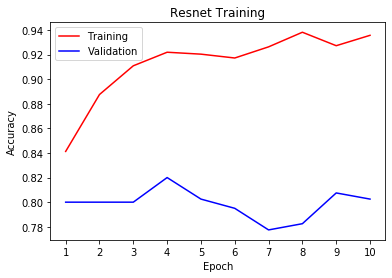

In [123]:
plot_accuracy(history, 'Resnet Training')

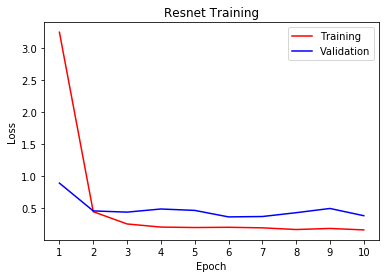

In [124]:
plot_loss(history, 'Resnet Training')

In [118]:
conv_model = Sequential()

conv_model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Flatten())
conv_model.add(Dense(512, activation='relu'))
conv_model.add(Dense(5, activation='sigmoid'))



conv_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [119]:
conv_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 256)      

In [120]:
history_conv = conv_model.fit_generator(trn_gen, 
                              steps_per_epoch=200, 
                              validation_data=val_gen, 
                              validation_steps=50, 
                              epochs=10)

Epoch 1/10
200/200 [==============================] - 104s 518ms/step - loss: 0.4235 - acc: 0.8107 - val_loss: 0.3446 - val_acc: 0.8050
Epoch 2/10
200/200 [==============================] - 105s 523ms/step - loss: 0.3599 - acc: 0.8303 - val_loss: 0.3661 - val_acc: 0.8299
Epoch 3/10
200/200 [==============================] - 105s 524ms/step - loss: 0.3523 - acc: 0.8411 - val_loss: 0.3164 - val_acc: 0.8408
Epoch 4/10
200/200 [==============================] - 112s 559ms/step - loss: 0.3388 - acc: 0.8525 - val_loss: 0.3366 - val_acc: 0.8675
Epoch 5/10
200/200 [==============================] - 108s 538ms/step - loss: 0.3301 - acc: 0.8557 - val_loss: 0.4334 - val_acc: 0.8283
Epoch 6/10
200/200 [==============================] - 115s 576ms/step - loss: 0.3239 - acc: 0.8611 - val_loss: 0.3385 - val_acc: 0.8486
Epoch 7/10
200/200 [==============================] - 112s 562ms/step - loss: 0.3215 - acc: 0.8626 - val_loss: 0.4799 - val_acc: 0.8595
Epoch 8/10
200/200 [============================

In [125]:
conv_model.evaluate_generator(trn_gen)

[0.2549809217453003, 0.8648634552955627]

In [126]:
conv_model.evaluate_generator(val_gen)

[0.23706145584583282, 0.8688014149665833]

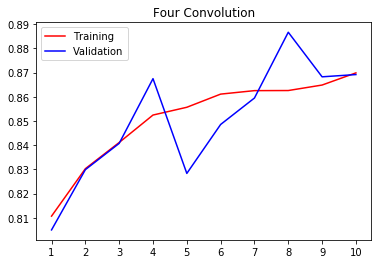

In [127]:
plot_accuracy(history_conv, 'Four Convolution')

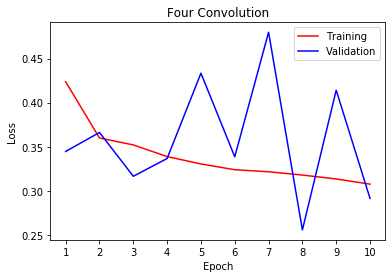

In [128]:
plot_loss(history_conv, 'Four Convolution')

In [132]:
conv_model2 = Sequential()

conv_model2.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu', padding='same'))
conv_model2.add(MaxPool2D((2, 2)))
conv_model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
conv_model2.add(MaxPool2D((2, 2)))
conv_model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
conv_model2.add(MaxPool2D((2, 2)))
# conv_model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# conv_model2.add(MaxPool2D((2, 2)))
# conv_model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# conv_model2.add(MaxPool2D((2, 2)))
conv_model2.add(Flatten())
conv_model2.add(Dense(512, activation='relu'))
conv_model2.add(Dense(5, activation='sigmoid'))



conv_model2.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [133]:
conv_model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 41472)            

In [134]:
history_conv2 = conv_model2.fit_generator(trn_gen, 
                              steps_per_epoch=200, 
                              validation_data=val_gen, 
                              validation_steps=50, 
                              epochs=10)

Epoch 1/10
200/200 [==============================] - 106s 529ms/step - loss: 0.3934 - acc: 0.8092 - val_loss: 0.3098 - val_acc: 0.8247
Epoch 2/10
200/200 [==============================] - 108s 540ms/step - loss: 0.3504 - acc: 0.8394 - val_loss: 0.3141 - val_acc: 0.8613
Epoch 3/10
200/200 [==============================] - 103s 514ms/step - loss: 0.3401 - acc: 0.8544 - val_loss: 0.3328 - val_acc: 0.8538
Epoch 4/10
200/200 [==============================] - 100s 502ms/step - loss: 0.3277 - acc: 0.8592 - val_loss: 0.2269 - val_acc: 0.8772
Epoch 5/10
200/200 [==============================] - 110s 548ms/step - loss: 0.3248 - acc: 0.8620 - val_loss: 0.3432 - val_acc: 0.8674
Epoch 6/10
200/200 [==============================] - 115s 573ms/step - loss: 0.3135 - acc: 0.8648 - val_loss: 0.2612 - val_acc: 0.8745
Epoch 7/10
200/200 [==============================] - 105s 526ms/step - loss: 0.3130 - acc: 0.8651 - val_loss: 0.2455 - val_acc: 0.8718
Epoch 8/10
200/200 [============================

In [135]:
conv_model2.evaluate_generator(trn_gen)

[0.24978137016296387, 0.8821313977241516]

In [136]:
conv_model2.evaluate_generator(val_gen)

[0.4734634757041931, 0.8911253213882446]

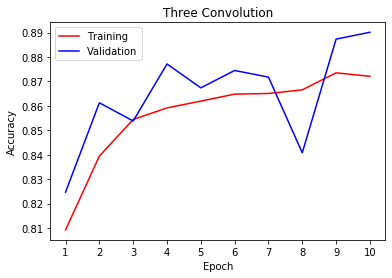

In [137]:
plot_accuracy(history_conv2, 'Three Convolution')

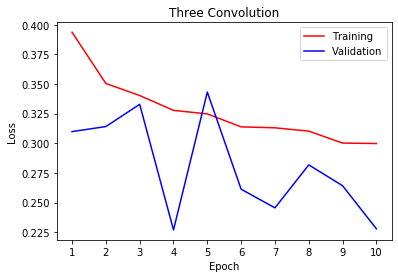

In [138]:
plot_loss(history_conv2, 'Three Convolution')

In [88]:
class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = batch_size
        self._shape = x.shape        
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)

    def __len__(self):
        return self._shape[0] // self.batch_size

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [36]:
# train_gen = datagen.flow(x_trn, y_trn, batch_size=20)
# valid_gen = datagen.flow(x_val, y_val, batch_size=20)

s_datagen = ImageDataGenerator(rescale=1.0/255, 
                               rotation_range=40, 
                               width_shift_range=0.2, 
                               height_shift_range=0.2, 
                               shear_range=0.2, 
                               zoom_range=0.2,
                               horizontal_flip=True)

bgen = BalancedDataGenerator(x_trn, y_trn, s_datagen, batch_size=32)
steps_per_epoch = bgen.steps_per_epoch

In [37]:
# bgen_vl = datagen.flow(x_val, y_val, batch_size=32)
# steps_val = bgen_vl.steps_per_epoch

In [38]:
valid_gen = datagen.flow(x_val, y_val, batch_size=32)

In [39]:
steps_per_epoch, steps_val

(579, 64)

In [48]:
history = model.fit_generator(bgen, 
                              steps_per_epoch=steps_per_epoch, 
                              validation_data=valid_gen, 
                              validation_steps=len(x_val)//32, 
                              epochs=10)

Epoch 1/10
579/579 [==============================] - 3569s 6s/step - loss: 0.7329 - acc: 0.7209 - val_loss: 1.0879 - val_acc: 0.6974
Epoch 2/10
579/579 [==============================] - 3551s 6s/step - loss: 0.5215 - acc: 0.8031 - val_loss: 2.2688 - val_acc: 0.1298
Epoch 3/10
579/579 [==============================] - 3627s 6s/step - loss: 0.4656 - acc: 0.8258 - val_loss: 2.5201 - val_acc: 0.1239
Epoch 4/10
579/579 [==============================] - 3881s 7s/step - loss: 0.4254 - acc: 0.8437 - val_loss: 2.1979 - val_acc: 0.0369
Epoch 5/10
579/579 [==============================] - 3731s 6s/step - loss: 0.4047 - acc: 0.8522 - val_loss: 2.0635 - val_acc: 0.0339
Epoch 6/10
579/579 [==============================] - 3626s 6s/step - loss: 0.3921 - acc: 0.8556 - val_loss: 1.9155 - val_acc: 0.0310
Epoch 7/10
579/579 [==============================] - 3642s 6s/step - loss: 0.3725 - acc: 0.8631 - val_loss: 2.1238 - val_acc: 0.0428
Epoch 8/10
579/579 [==============================] - 3636s 6s

In [49]:
model.evaluate_generator(bgen)

[2.2005739212036133, 0.25015702843666077]

In [50]:
model.evaluate_generator(valid_gen)

[3.1303462982177734, 0.035211268812417984]

In [32]:
y_trn

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [33]:
y_trn_pred = model.predict(x_trn)

In [34]:
y_val_pred = model.predict(x_val)

In [35]:
y_trn_pred

array([[4.4343080e-03, 1.4488957e-03, 9.8969406e-01, 4.4227676e-03],
       [1.7619923e-06, 1.0551557e-07, 9.9999809e-01, 1.4338494e-08],
       [2.9367459e-04, 5.9036534e-05, 9.9931002e-01, 3.3724587e-04],
       ...,
       [5.7238364e-04, 1.6210042e-04, 9.9840242e-01, 8.6316268e-04],
       [8.1247366e-05, 1.8141752e-04, 9.9636590e-01, 3.3714673e-03],
       [1.9814749e-04, 2.8437789e-05, 9.9947459e-01, 2.9880885e-04]],
      dtype=float32)

In [43]:
p = list(y_trn_pred[0])

In [47]:
p_mx = max(p)

In [48]:
p.index(p_mx)

2

In [49]:
def convert_class(y):
    
    lb_list = []
    
    for i in y:
        
        i = list(i)
        
        i_mx = max(i)
        
        i_id = i.index(i_mx)
        
        lb_list.append(i_id)
        
    return np.array(lb_list)

In [51]:
y_tr_lb = convert_class(y_trn)

In [52]:
y_tr_lb_pred = convert_class(y_trn_pred)

In [53]:
y_vl_lb = convert_class(y_val)
y_vl_lb_pred = convert_class(y_val_pred)

In [57]:
y_trn

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [65]:
# training

confusion_matrix(y_tr_lb, y_tr_lb_pred)

array([[ 132,    4,  671,    0],
       [   2,   16,  204,    0],
       [   6,    0, 4629,    0],
       [   0,    0,  721,    0]])

In [67]:
print(classification_report(y_tr_lb, y_tr_lb_pred))

              precision    recall  f1-score   support

           0       0.94      0.16      0.28       807
           1       0.80      0.07      0.13       222
           2       0.74      1.00      0.85      4635
           3       0.00      0.00      0.00       721

    accuracy                           0.75      6385
   macro avg       0.62      0.31      0.32      6385
weighted avg       0.69      0.75      0.66      6385



In [71]:
accuracy_score(y_tr_lb, y_tr_lb_pred)

0.748159749412686

In [68]:
# validation

confusion_matrix(y_vl_lb, y_vl_lb_pred)

array([[ 16,   1,  73,   0],
       [  0,   4,  21,   0],
       [  0,   0, 515,   0],
       [  0,   0,  80,   0]])

In [69]:
print(classification_report(y_vl_lb, y_vl_lb_pred))

              precision    recall  f1-score   support

           0       1.00      0.18      0.30        90
           1       0.80      0.16      0.27        25
           2       0.75      1.00      0.86       515
           3       0.00      0.00      0.00        80

    accuracy                           0.75       710
   macro avg       0.64      0.33      0.36       710
weighted avg       0.70      0.75      0.67       710



In [72]:
accuracy_score(y_vl_lb, y_vl_lb_pred)

0.7535211267605634

## Second model

In [73]:
model = Sequential()

model.add(resnet)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

In [74]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=len(x_trn)//20, 
                              validation_data=valid_gen, 
                              validation_steps=len(x_val)//20, 
                              epochs=10)

Epoch 1/10
319/319 [==============================] - 546s 2s/step - loss: 0.5471 - acc: 0.7884 - val_loss: 1.1094 - val_acc: 0.7214
Epoch 2/10
319/319 [==============================] - 466s 1s/step - loss: 0.2994 - acc: 0.8742 - val_loss: 0.8498 - val_acc: 0.7304
Epoch 3/10
179/319 [===============>..............] - ETA: 2:59 - loss: 0.2055 - acc: 0.9128

KeyboardInterrupt: 